# Laboratory 2

### Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import pandas as pd


TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfaces

[Available colors](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Available points markers](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines
    
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Next')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Previous')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Add point')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Add line')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Add figure')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Solution

In [3]:
import random
import math
%matplotlib notebook

## Generating sets of points

### Parameters for generating points

In [4]:
TOLERANCE = 1e-12

# a) number of points, points drawn from interval [a, b]
n_A, a, b = 100, -100, 100

# b) number of points, centre and radius of the circle
n_B, centre, R = 100, (0, 0), 10

# c) number of points, vertices of the rectangle
# put vertices in the list in this order: bottom left corner, top left corner, top right corner, bottom right corner
n_C, vertices_C = 100, [(-10, -10), (-10, 10), (10, 10), (10, -10)]

# d) vertices of the square, number of points on the axes, number of points on the diagonals
# put vertices in the list in this order: bottom left corner, top left corner, top right corner, bottom right corner
vertices_D, n_axes, m_diagonals = [(0, 0), (0, 10), (10, 10), (10, 0)], 25, 20
bot_left, top_left, top_right, bot_right = vertices_D

### a) n random points from [a, b]

<IPython.core.display.Javascript object>


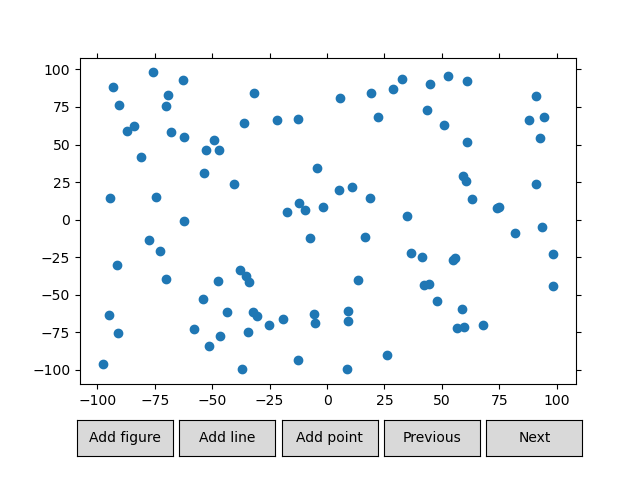

In [24]:
A = [(random.uniform(a, b), random.uniform(a, b)) for _ in range(n_A)]

plot = Plot(points = [PointsCollection(A)])
plot.draw()

### b) n random points on the circle with parametrized centre and radius

<IPython.core.display.Javascript object>


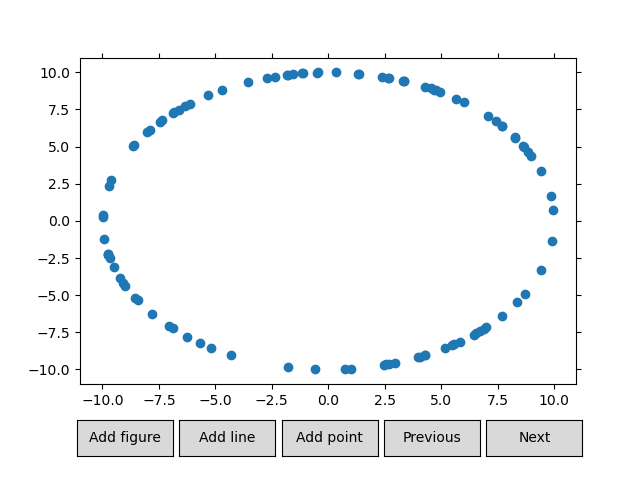

In [25]:
B = []
for _ in range(n_B):
    fi = random.uniform(0, 2 * math.pi)
    B.append((R * math.cos(fi) + centre[0], R * math.sin(fi) + centre[1]))

plot = Plot(points = [PointsCollection(B)])
plot.draw()

### c) n random points lying on sides of the rectangle with parametrized vertices

<IPython.core.display.Javascript object>


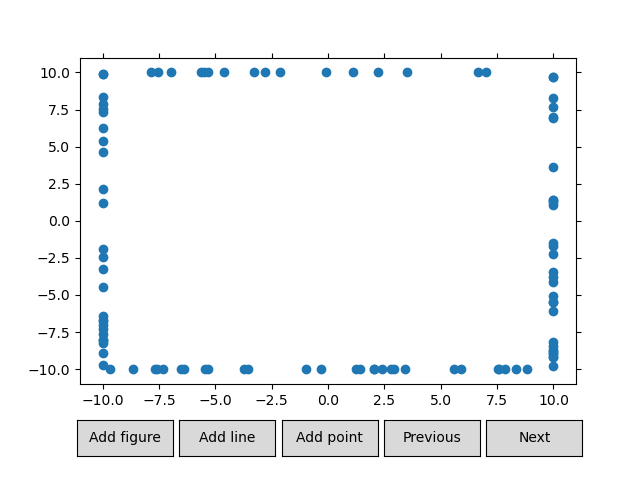

In [26]:
C = []
for _ in range(n_C):
    # side == 0: left side of the rectangle, side == 1: top side, side == 2: right side, side == 3: bottom side 
    side = random.choice((0, 1, 2, 3))
    
    #two points describing the side of the rectangle
    x_u, y_u = vertices_C[side]
    x_v, y_v = vertices_C[(side + 1) % 4]
    if side == 0:
        x, y = x_u, random.uniform(y_u, y_v)
    elif side == 1:
        x, y = random.uniform(x_u, x_v), y_u
    elif side == 2:
        x, y = x_u, random.uniform(y_v, y_u)
    else:
        x, y = random.uniform(x_v, x_u), y_u
    
    C.append((x, y))

plot = Plot(points = [PointsCollection(C)])
plot.draw()

### d) parametrized vertices, n random points on each of the two sides of the square lying on the axes and m random points on each of the two diagonals of the square

<IPython.core.display.Javascript object>


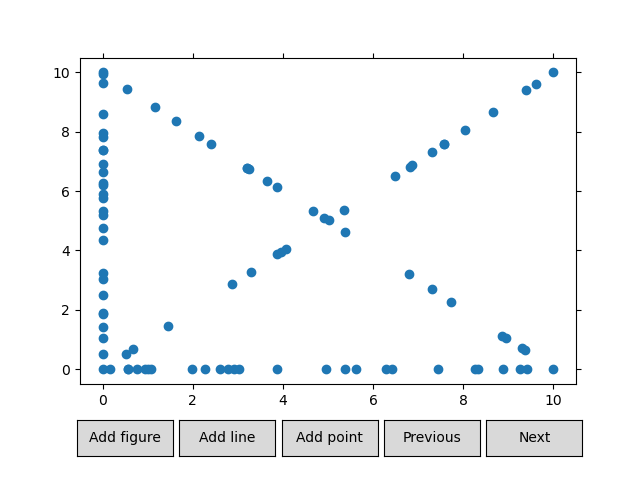

In [27]:
D = [v for v in vertices_D]
min_x, max_x, min_y, max_y = bot_left[1], top_left[1], bot_left[0], bot_right[0]
for i in range(max(n_axes, m_diagonals)):
    if i < n_axes:
        D.append((0, random.uniform(min_y, max_y)))
        D.append((random.uniform(min_x, max_x), 0))
    if i < m_diagonals:
        x1 = random.uniform(min_x, max_x)
        D.append((x1, -x1 + bot_right[1] + bot_right[0]))
        x2 = random.uniform(min_x, max_x)
        D.append((x2, x2 + (top_right[1] - top_right[0])))
    
plot = Plot(points = [PointsCollection(D)])
plot.draw()

### Function for computing 2x2 determinant

In [9]:
def det2x2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

### Function for computing the distance between two points

In [10]:
def dist(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** (1/2)

## Convex Hull algorithms:

### 1. Graham scan algorithm

In [11]:
from functools import cmp_to_key

# function used to compare points by their polar angle in sorting function
def compare(P0, P1, P2):
    orientation = det2x2(P0, P1, P2)
    # return -1 means P2 is less than P1, return 1 means P2 is greater than P1
    if orientation > TOLERANCE:
        return -1
    if orientation < -TOLERANCE:
        return 1
    if dist(P0, P1) <= dist(P0, P2):
        return -1
    return 1


# helper function for visualization
def add_to_scene(scenes, stack, points, points_org, i):
    scenes.append(Scene([PointsCollection(points_org), PointsCollection(stack.copy(), color="red"),
                             PointsCollection([points[i]], color="aqua")],
                            [LinesCollection([(stack[j], stack[j + 1]) for j in range(len(stack) - 1)], color="red"),
                             LinesCollection([(points[i], stack[-1])], color="aqua")]))

    
# find the lowest y-coordinate and leftmost point - P0
def findMin(points, n):
    P0, index = points[0], 0
    for i in range(1, n):
        x, y = points[i]
        if y <= P0[1] and x < P0[0]:
            P0 = x, y
            index = i
    return P0, index
      
    
def CH_graham_scan(points_org, visualize = True):
    n = len(points_org)
    points = points_org.copy()
    P0, index = findMin(points, n)     
    points[0], points[index] = points[index], points[0]
    
    # sorting points by polar angle with P0
    points.sort(key = cmp_to_key(lambda P1, P2: compare(P0, P1, P2)))

    # keeping only the farthest points if some points have the same polar angle
    m = 1
    i = 1
    while i < n:
        while i < n - 1 and -TOLERANCE < det2x2(P0, points[i], points[i + 1]) < TOLERANCE:
            i += 1
            
        points[m] = points[i]
        m += 1
        i += 1
      
    if m < 3:
        return [], [Scene([PointsCollection(points_org)])]
    
    scenes = []
    stack = []
    stack.append(points[0])
    stack.append(points[1])
    stack.append(points[2])
    for i in range(3, m):
        if visualize:
            add_to_scene(scenes, stack, points, points_org, i)
            
        while len(stack) > 1 and det2x2(stack[-2], stack[-1], points[i]) < TOLERANCE:
            stack.pop()
        
        stack.append(points[i])
        
    
    if visualize:
        lines = [(stack[i], stack[i + 1]) for i in range(len(stack) - 1)]
        lines.append((stack[-1], stack[0]))

        #add final scene to scenes
        scenes = [Scene([PointsCollection(points_org), PointsCollection(stack, color="red")],
                            [LinesCollection(lines, color="red")])] + scenes
    return stack, scenes

### Graham scan for subpoint a)

<IPython.core.display.Javascript object>


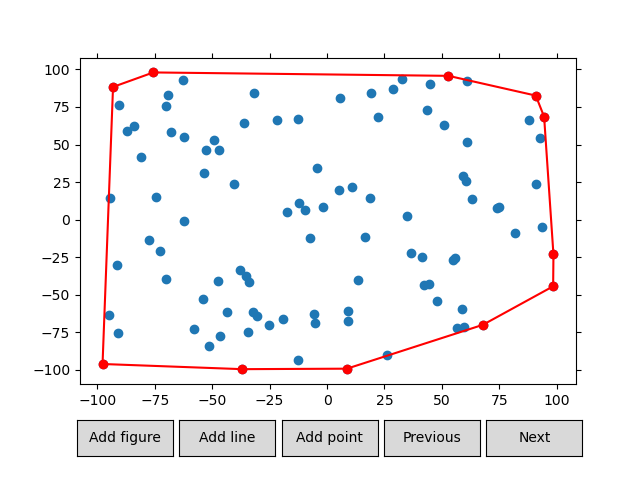

In [28]:
CH_GS_A = CH_graham_scan(A)
plot = Plot(scenes = CH_GS_A[1])
plot.draw()

### Graham scan for subpoint b)

<IPython.core.display.Javascript object>


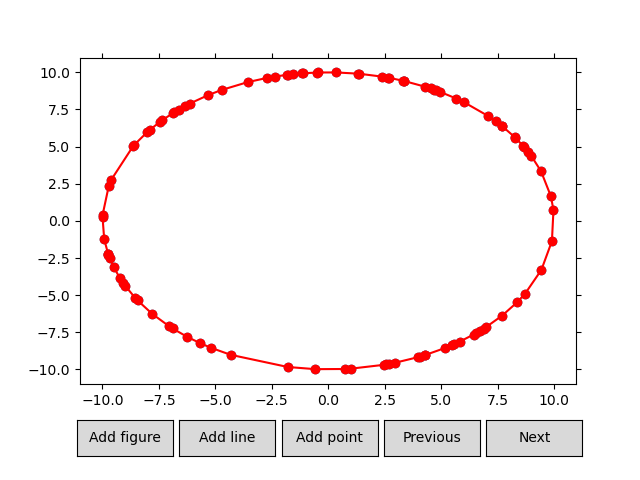

In [29]:
CH_GS_B = CH_graham_scan(B)
plot = Plot(scenes = CH_GS_B[1])
plot.draw()

### Graham scan for subpoint c)

<IPython.core.display.Javascript object>


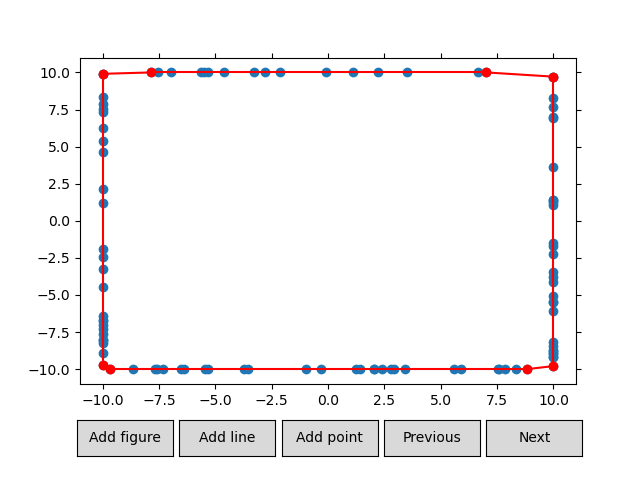

In [30]:
CH_GS_C = CH_graham_scan(C)
plot = Plot(scenes = CH_GS_C[1])
plot.draw()

### Graham scan for subpoint d)

<IPython.core.display.Javascript object>


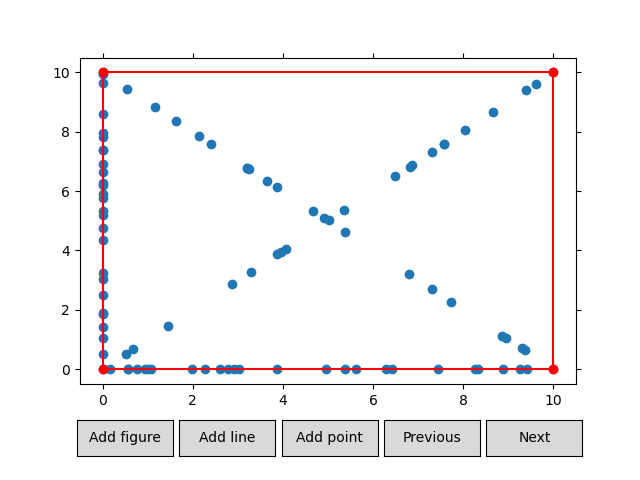

In [31]:
CH_GS_D = CH_graham_scan(D)
plot = Plot(scenes = CH_GS_D[1])
plot.draw()

### 2. Gift wrapping algorithm (Jarvis)

In [16]:
def CH_gift_wrapping(points, visualize = True):
    n = len(points)
    hull = []
    scenes = []
    pointOnHull, _ = findMin(points, n)
    
    while True:
        hull.append(pointOnHull)
        endpoint = points[0]
        for i in range(n):
            orient = det2x2(hull[-1], endpoint, points[i])
            if points[i] == pointOnHull:
                continue
            
            if orient > TOLERANCE or -TOLERANCE <= orient <= TOLERANCE and dist(pointOnHull, points[i]) > dist(pointOnHull, endpoint):
                endpoint = points[i]
                    
            if visualize:
                add_to_scene(scenes, hull, points, points, i)
        
        
        pointOnHull = endpoint
        if endpoint == hull[0]:
            if visualize:
                lines = [(hull[i], hull[i + 1]) for i in range(len(hull) - 1)]
                lines.append((hull[-1], hull[0]))
                scenes = [Scene([PointsCollection(points), PointsCollection(hull, color="red")],
                            [LinesCollection(lines, color="red")])] + scenes
            break
    
    return hull, scenes

### Gift wrapping algorithm for subpoint a)

<IPython.core.display.Javascript object>


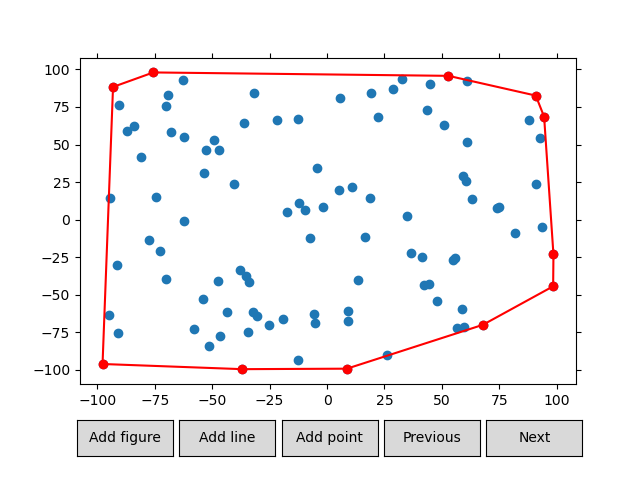

In [32]:
CH_GW_A = CH_gift_wrapping(A)
plot = Plot(scenes = CH_GW_A[1])
plot.draw()

### Gift wrapping algorithm for subpoint b)

<IPython.core.display.Javascript object>


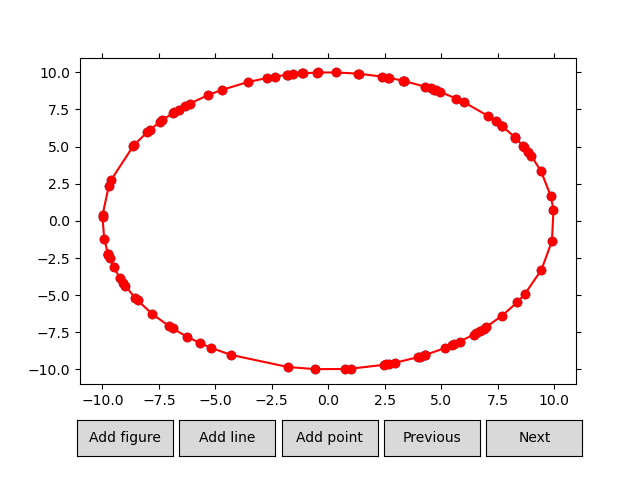

In [33]:
CH_GW_B = CH_gift_wrapping(B)
plot = Plot(scenes = CH_GW_B[1])
plot.draw()

### Gift wrapping algorithm for subpoint c)

<IPython.core.display.Javascript object>


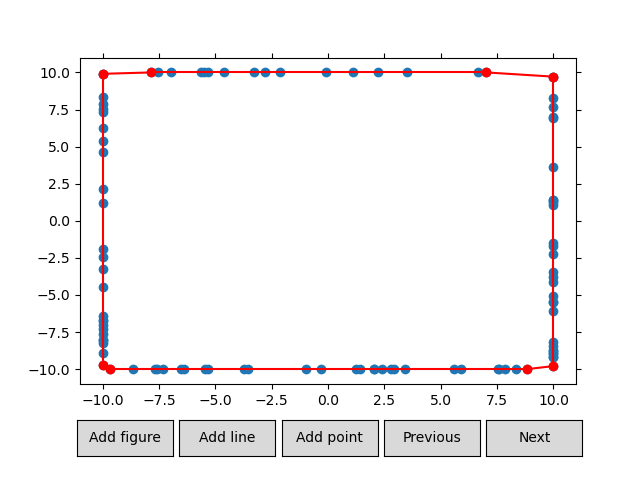

In [34]:
CH_GW_C = CH_gift_wrapping(C)
plot = Plot(scenes = CH_GW_C[1])
plot.draw()

### Gift wrapping algorithm for subpoint d)

<IPython.core.display.Javascript object>


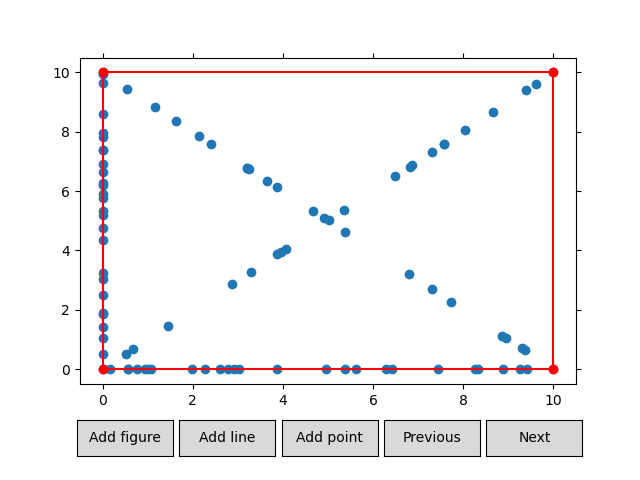

In [35]:
CH_GW_D = CH_gift_wrapping(D)
plot = Plot(scenes = CH_GW_D[1])
plot.draw()

## Comparing execution times of algorithms for all sets

In [21]:
from time import time
def compare_speed(dataset, points):
    start = time()
    print(dataset)
    hull_graham, _ = CH_graham_scan(points, False)
    print("Graham: points in convex hul -", len(hull_graham), "time -", time() - start)
    start = time()
    hull_jarvis, _ = CH_gift_wrapping(points, False)
    print("Jarvis: points in convex hul -", len(hull_jarvis), "time -", time() - start)
    print("----------------------------")

In [36]:
compare_speed("Subpoint a)", A)
compare_speed("Subpoint b)", B)
compare_speed("Subpoint c)", C)
compare_speed("Subpoint d)", D)

Subpoint a)
Graham: points in convex hul - 11 time - 0.0010123252868652344
Jarvis: points in convex hul - 11 time - 0.0010035037994384766
----------------------------
Subpoint b)
Graham: points in convex hul - 100 time - 0.0009963512420654297
Jarvis: points in convex hul - 100 time - 0.009012937545776367
----------------------------
Subpoint c)
Graham: points in convex hul - 8 time - 0.0009913444519042969
Jarvis: points in convex hul - 8 time - 0.0010030269622802734
----------------------------
Subpoint d)
Graham: points in convex hul - 4 time - 0.002000570297241211
Jarvis: points in convex hul - 4 time - 0.0010025501251220703
----------------------------


## Function for saving the convex hull points to file

In [23]:
def save_CH_to_file(points, CHAlg):
    hull = CHAlg(points, False)[0]
    with open("convex_hull.txt", 'w') as file:
        file.write("\n".join(str(point) for point in hull))